# Siamese Bert!

sbert

## Carichiamo il dataset

In [1]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

#load pandas dataframe (rimuovo le righe vuote che putroppo sono presenti)
vax_series = pd.read_csv('data/posts_cleaned_it_only.csv')

vax_series.dropna(inplace=True)

#salviamo una lista di lista con le parole tokenizzate
#tokenized_sent = []
#for s in vax_series["clean_text"]:
    #print(word_tokenize(s))
   #tokenized_sent.append(word_tokenize(s) )
#print(tokenized_sent)

vax_text = vax_series['clean_text'].tolist()




[nltk_data] Downloading package punkt to /home/apsev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Caricamento del modello

Carichiamo il modello pre-addestrato 'distiluse-base-multilingual-cased-v1' Multi-Lingual model of Universal Sentence Encoder for 15 languages: Arabic, Chinese, Dutch, English, French, German, Italian, Korean, Polish, Portuguese, Russian, Spanish, Turkish.

In [2]:
#bert-base-nli-mean-tokens

from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

2023-05-04 18:12:22.232028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 18:12:23.707622: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-04 18:12:23.707803: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-04 18:12:23.707809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Creazione Embedding

Creiamo un vettore per ogni frase del dataset

In [3]:
#sentence_embeddings = sbert_model.encode(tokenized_sent[10])
sentence_embeddings = sbert_model.encode(vax_text)
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
#print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 512


## Funzioni di pulizia

In questo caso usiamo lo stemming di snowball

In [4]:
#loading and cleaning dataset with spacy
import spacy
import pandas as pd
import regex as re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
it_stopwords = stopwords.words('italian')

#the stemmer requires a language parameter
snow_stemmer = SnowballStemmer(language='italian')

def cleaner(s):
    #removing numbers and special caracters
    s = re.sub(r'[^a-z\s]', '', s).strip()
    #remving multiple spaces
    s = " ".join(s.split()).strip()
    #removing apostrophe and splititng words
    s = s.replace("'", " ")
    #some manual corrections
    #s = s.replace(' accino', ' vaccino')
    #removing stopwords with nltk
    s = stop_word_remover(s)
    #stemming with nltk
    s = stemmer(s)

    return s


def stop_word_remover(text):
    word_tokens = word_tokenize(text)
    word_list = [word for word in word_tokens if word.lower() not in it_stopwords]
    return " ".join(word_list)

def stemmer(text):
    words = word_tokenize(text)
    stem_words = [snow_stemmer.stem(word) for word in words]
    return " ".join(stem_words)
  
#query = "Tu apri il tuo armadio e scegli, non lo so, quel maglioncino azzurro infeltrito per esempio, perché vuoi gridare al mondo che ti prendi troppo sul serio per curarti di cosa ti metti addosso" 
#frase diavolo veste prada: 0.3 / 0.2
query = "i vaccini sono pericolosi hanno fatto morire tante persone"
#frase novax: 0.4
#cleaning
#query = cleaner(query)

print(query)


2023-05-04 18:13:26.106220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 18:13:26.107137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-05-04 18:13:26.107252: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-05-04 18:13:26.107323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-05-04 18:13:26.107373: W tensorflow/co

i vaccini sono pericolosi hanno fatto morire tante persone


[nltk_data] Downloading package stopwords to /home/apsev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Distanza dal centro del cluster con SBERT

Usiamo Kmeans per creare il cluster e ne determiniamo il centro. Successivamente calcoliamo la distanza di ogni frase dal centro del cluster.

In [5]:
import numpy as np
# k-means - Inertia as the number of clusters varies
from sklearn.cluster import KMeans
from sklearn import preprocessing  # to normalise existing X
from scipy.spatial.distance import cosine

#create a numpy array with all the vectors
vectors = np.zeros((len(sentence_embeddings), 512))
for i in range(len(sentence_embeddings)):
    vectors[i] = sentence_embeddings[i]

#normalize
vectors = preprocessing.normalize(vectors)

X_train = pd.DataFrame(vectors)

n_clusters = 1
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
# n_jobs = 2
kMeans_inertia = pd.DataFrame(data=[],index=range(2), \
columns=['inertia'])

kmeansfirst = KMeans(n_clusters=n_clusters, n_init=n_init, \
    max_iter=max_iter, tol=tol, random_state=random_state )
   
kmeansfirst.fit(X_train)

center = kmeansfirst.cluster_centers_
center.shape

print(kmeansfirst.score(vectors))

#calculate the distance between each point and the center
X_train['distance'] = X_train.apply(lambda x: cosine(x, center[0]), axis=1)

X_train["distance"].describe()
   

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
-13557.258225541384


count    19104.000000
mean         0.461164
std          0.148299
min          0.177492
25%          0.361479
50%          0.420196
75%          0.511904
max          1.096289
Name: distance, dtype: float64

## Test
Proviamo come la distanza dei vettori di anomalie e non anomalie varia.

In [6]:
#calculating the distance from the center
from gensim import similarities
from scipy.spatial.distance import cosine, euclidean
import spacy
import pandas as pd
import regex as re
import numpy as np


#definiziamo una lista di frasi che dovrebbero essere classificate come anomalie
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi", "una frase che parla di tutt'altro ma il modo lunghissimo per tentare di ingannare il caro amico use" ]
novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al vaccino", "non farò mai il booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]
#provo con un testo casuale
#testo = "i vaccini fanno morire le persone anche se ci dicono di no"
#test_vector = sbert_model.encode([anomalies])
#test_vector = model(testo)

cosine_distance = []
euclidean_distance = []
'''cosine_distance.append(  cosine(test_vector[0],center[0]) )
cosine_distance.append(  cosine(test_vector[0],center[1]) )
euclidean_distance.append (euclidean(test_vector[0],center[0]))
euclidean_distance.append(euclidean(test_vector[0],center[1]))

print("Distance score cosine 1 - 2:",cosine_distance[0],cosine_distance[1])
print("Distance score euclidean 1 - 2:",euclidean_distance[0],euclidean_distance[1])
print ("Euclidean distance sum:",sum(euclidean_distance))'''

print("Anomalies score:")
for i in anomalies:
   
    test_vector = sbert_model.encode([i])
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center[0])
    euclidean_distance = euclidean(test_vector[0],center[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)


print("Novax score:")
for i in novax_sentences:
    test_vector = sbert_model.encode([i])
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center[0])
    euclidean_distance = euclidean(test_vector[0],center[0])

    #cosine_distance_norm = cosine(test_vector_norm[0],center[0])
    #euclidean_distance_norm = euclidean(test_vector_norm[0],center[0])
   
    print ("Cosine:",cosine_distance)
    #print ("Cosine norm:",cosine_distance_norm,"Euclidean norm: ",cosine_distance_norm)

Anomalies score:
Cosine: 0.9945567857301324
Cosine: 0.7886830584412956
Cosine: 0.9652166408619733
Cosine: 0.9260961465733119
Novax score:
Cosine: 0.34597523165638133
Cosine: 0.3824881443677176
Cosine: 0.3861222770442061
Cosine: 0.8720778624599448
Cosine: 0.6634075722739347
Cosine: 0.291304792296342


## PCA + Kmeans

In [20]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np

n_clusters = 1
n_init = 10
max_iter = 3000
tol = 0.0001
random_state = 2018
# n_jobs = 2
 
#Load Data
data = sentence_embeddings
pca = PCA(3)
 
#Transform the data
df = pca.fit_transform(data)
 
df.shape

#Initialize the class object
kmeans_pca = KMeans(n_clusters=n_clusters, n_init=n_init, \
    max_iter=max_iter, tol=tol, random_state=random_state)
 
#predict the labels of clusters.
label = kmeans_pca.fit_predict(df)

center_pca = kmeans_pca.cluster_centers_
 
print(label)

[0 0 0 ... 0 0 0]


## Visualizzazione cluster con PCA

/home/apsev/.local/lib/python3.8/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


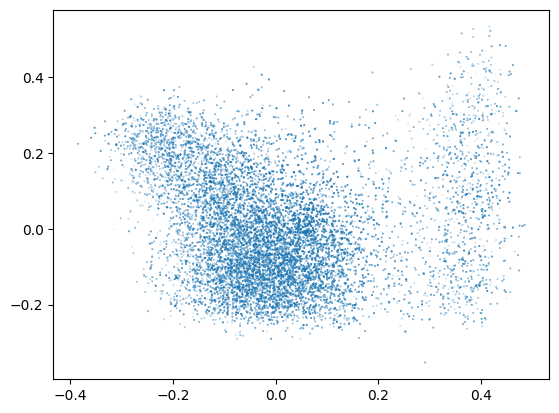

In [21]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = df[label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], filtered_label0[:,2])
plt.show()

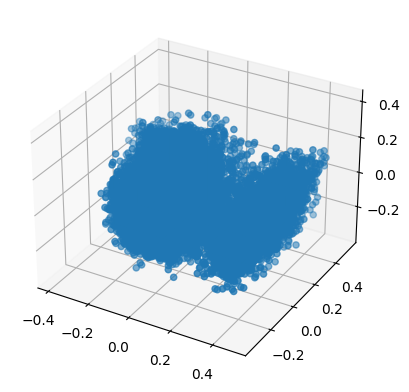

In [22]:
from mpl_toolkits import mplot3d
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(filtered_label0[:,0] , filtered_label0[:,1], filtered_label0[:,2])

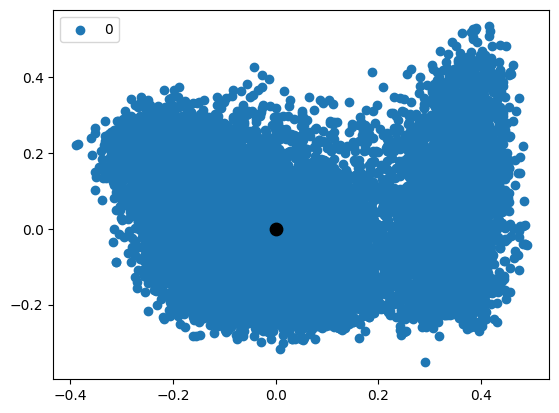

In [23]:
#Getting the Centroids

u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(center_pca[:,0] , center_pca[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

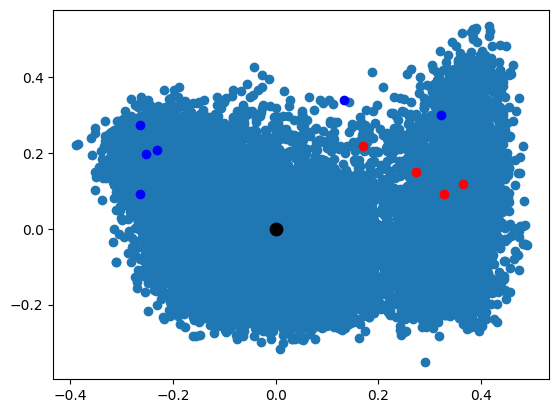

In [11]:
import matplotlib.pyplot as plt


novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al vaccino", "non farò mai il booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi", "una frase che parla di tutt'altro ma il modo lunghissimo per tentare di ingannare il caro amico use" ]
center_pca = preprocessing.normalize(center_pca)
plt.scatter(df[:,0] , df[:,1])
plt.scatter(center_pca[:,0] , center_pca[:,1] , s = 80, color = 'k')
for i in anomalies:
    test_vector = sbert_model.encode([i])
    test_vector = pca.transform(test_vector)
    test_vector_norm = preprocessing.normalize(test_vector)
    plt.scatter(test_vector[:,0] , test_vector[:,1], color = 'r')

for i in novax_sentences:
    test_vector = sbert_model.encode([i])
    test_vector = pca.transform(test_vector)
    test_vector_norm = preprocessing.normalize(test_vector)
    plt.scatter(test_vector[:,0] , test_vector[:,1], color = 'b')
    
#plotting the results

plt.show()

## Test con PCA

In [12]:
#creating a dataframe from the df array
df = pd.DataFrame(df)

#calculate the distance between each point and the center
df['distance'] = df.apply(lambda x: cosine(x, center_pca[0]), axis=1)
df["distance"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    19104.000000
mean         0.956245
std          0.631021
min          0.000003
25%          0.331453
50%          1.015361
75%          1.509586
90%          1.801584
95%          1.905900
99%          1.980282
max          1.999866
Name: distance, dtype: float64

In [13]:
#calculating the distance from the center
from gensim import similarities
from scipy.spatial.distance import cosine, euclidean
import spacy
import pandas as pd
import regex as re
import numpy as np


#definiziamo una lista di frasi che dovrebbero essere classificate come anomalie
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi", "una frase che parla di tutt'altro ma il modo lunghissimo per tentare di ingannare il caro amico use" ]
novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al vaccino", "non farò mai il booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]



print("Anomalies score:")
for i in anomalies:
    
    test_vector = sbert_model.encode([i])
    test_vector = pca.transform(test_vector)
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center_pca[0])
   
   
    print ("Cosine:",cosine_distance)


print("Novax score:")
for i in novax_sentences:
    test_vector = sbert_model.encode([i])
    test_vector = pca.transform(test_vector)
    test_vector_norm = preprocessing.normalize(test_vector)

    cosine_distance = cosine(test_vector[0],center_pca[0])
    
    print ("Cosine:",cosine_distance)

Anomalies score:
Cosine: 1.436088114976883
Cosine: 1.0016368409851566
Cosine: 1.6486236453056335
Cosine: 1.5366875529289246
Novax score:
Cosine: 0.19787704944610596
Cosine: 0.00877535343170166
Cosine: 0.07151150703430176
Cosine: 1.1451377719640732
Cosine: 0.8405634164810181
Cosine: 0.05865621566772461


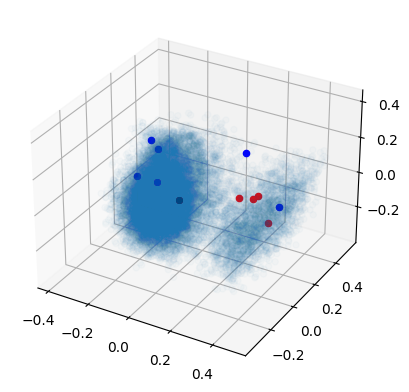

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

filtered_label0 = df

novax_sentences = ["i vaccini uccidono", "non mi voglio vaccinare", "no al vaccino", "non farò mai il booster", "dopo 4 dosi il sistema immunitario fritto", "i vaccini fanno morire le persone anche se ci dicono di no"]
anomalies = ["il cane gioca a palla","ho dovuto ripristinare il PC per togliere tutti i suoi malware", "bella giornata oggi", "una frase che parla di tutt'altro ma il modo lunghissimo per tentare di ingannare il caro amico use" ]
ax.scatter(filtered_label0[:,0] , filtered_label0[:,1], filtered_label0[:,2], alpha = 0.02)
ax.scatter(center_pca[:,0] , center_pca[:,1] , center_pca[:,2] , color = 'k')
for i in anomalies:
    test_enc = sbert_model.encode([i])
    test_vector = pca.transform(test_enc)
    ax.scatter(test_vector[:,0] , test_vector[:,1], test_vector[:,2], color = 'r')

for i in novax_sentences:
    test_enc = sbert_model.encode([i])
    test_vector = pca.transform(test_enc)
    ax.scatter(test_vector[:,0] , test_vector[:,1], test_vector[:,2], color = 'b')
    
#plotting the results

plt.show()